## Load lib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from modAL.models import ActiveLearner
import time
import struct
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling

--> install modAL before numpy else got modAL module not found

## Load data and preprocess it 

In [ ]:
def read_images(filename):
    with open(filename, 'rb') as file:
        magic_number, nb_images, nb_rows, nb_cols = struct.unpack('>IIII', file.read(16))
        assert magic_number == 2051, "Wrong file"
        image_data = np.fromfile(file, dtype=np.uint8).reshape(nb_images, nb_rows, nb_cols)
    return image_data

def read_targets(filename):
    with open(filename, 'rb') as file:
        magic_number, nb_items = struct.unpack('>II', file.read(8))
        assert magic_number == 2049, "Wrong file"
        targets = np.fromfile(file, dtype=np.uint8)
    return targets

In [3]:
path_images_file = '../t10k-images.idx3-ubyte'
path_to_targets = '../t10k-labels.idx1-ubyte'

In [4]:
X = read_images(path_images_file).reshape(-1, 28*28)
y = read_targets(path_to_targets)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Initial learning

In [6]:
n_initial = 100

In [7]:
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

In [9]:
# Init model
model = RandomForestClassifier()

# Init active learner
learner = ActiveLearner(
    estimator=model,
    X_training=X_initial, y_training=y_initial,
    query_strategy=uncertainty_sampling
)

# Train initial model and learner
learner.teach(X_initial, y_initial)

# Predict initial accuracy
initial_accuracy = accuracy_score(y_test, learner.predict(X_test))
print(f"Initial accuracy: {initial_accuracy}")

Initial accuracy: 0.683


/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
## init and train passive model
model_passif = RandomForestClassifier()
model_passif.fit(X_initial, y_initial)

# Predict initial accuracy
initial_accuracy = accuracy_score(y_test, learner.predict(X_test))
print(f"Initial accuracy: {initial_accuracy}")

Initial accuracy: 0.683


## Active learning example

In [11]:
mask = np.ones(len(X_train), dtype=bool)
mask[initial_idx] = False

## pool active learning method
X_train_actif, y_train_actif = X_train[mask], y_train[mask]

## pool passive learning method
X_train_passif, y_train_passif = X_train[mask], y_train[mask]

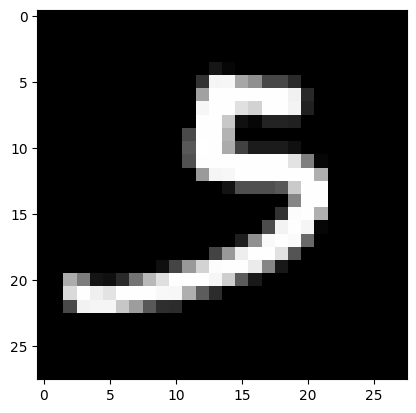

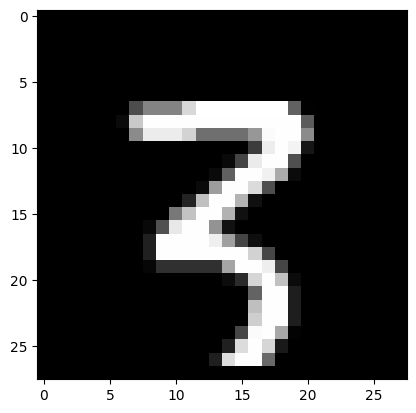

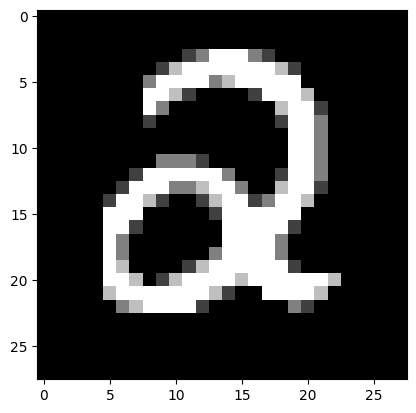

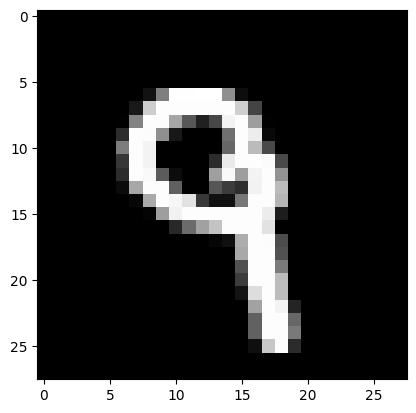

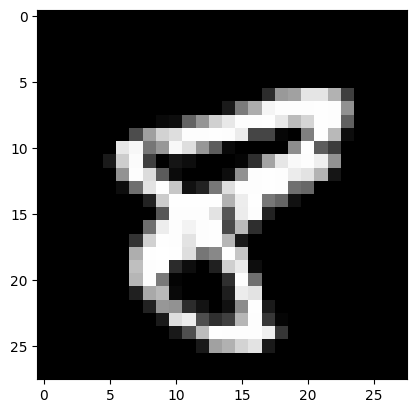

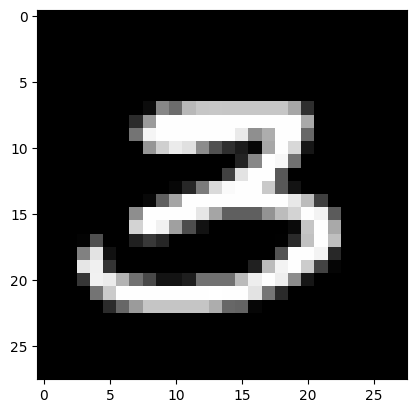

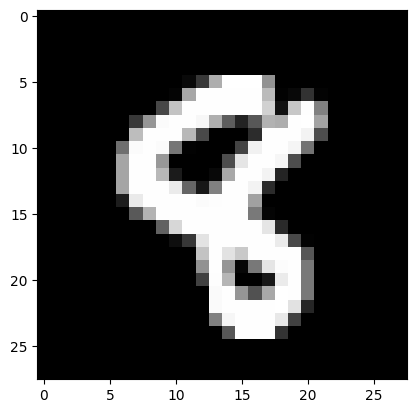

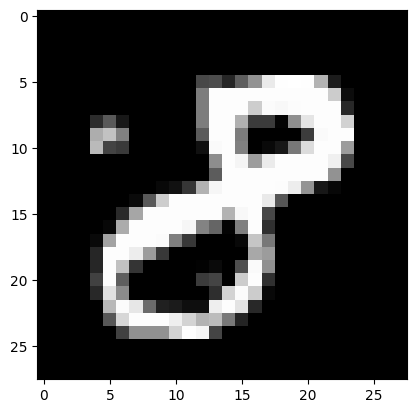

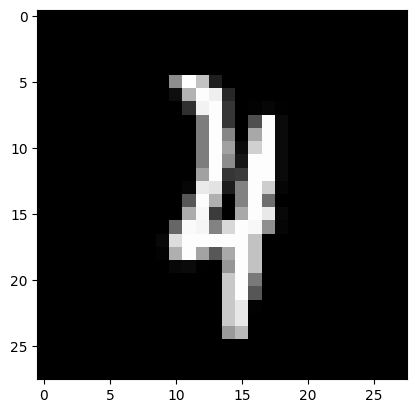

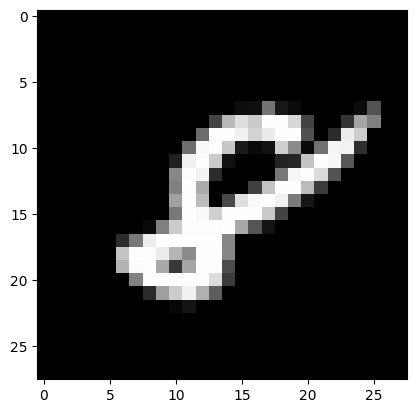

In [11]:
n_queries = 10
accuracy_model_actif = [initial_accuracy]
accuracy_model_passif = [initial_accuracy]

for i in range(n_queries):
    
    # Ask learner for a new sample
    query_idx, query_instance = learner.query(X_train_actif)
    
    # Show image and ask user to labelize it 
    plt.imshow(query_instance.reshape(28, 28), cmap='gray')
    plt.show()
    
    time.sleep(2)
    label = int(input("Veuillez fournir le label pour cette image: "))
    
    # Retrain model with new sample and delete it from training set
    learner.teach(query_instance.reshape(1, -1), np.array([label]))
    X_train_actif = np.delete(X_train_actif, query_idx, axis=0)
    y_train_actif = np.delete(y_train_actif, query_idx, axis=0)
    
    # Select random sample for passive learning
    query_idx_passif = np.random.randint(0, len(X_train_passif))
    query_instance_passif = X_train_passif[query_idx_passif]
    label_passif = y_train_passif[query_idx_passif]
    
    # Retrain passif model with new sample and remove it from dataset 
    X_initial = np.vstack((X_initial, query_instance_passif))
    y_initial = np.hstack((y_initial, label_passif))
    
    model_passif.fit(X_initial, y_initial)
    X_train_passif = np.delete(X_train, query_idx_passif, axis=0)
    y_train_passif = np.delete(y_train, query_idx_passif, axis=0)
    
    # Show new accuracy
    accuracy_model_actif.append(accuracy_score(y_test, learner.predict(X_test)))
    accuracy_model_passif.append(accuracy_score(y_test, model_passif.predict(X_test)))


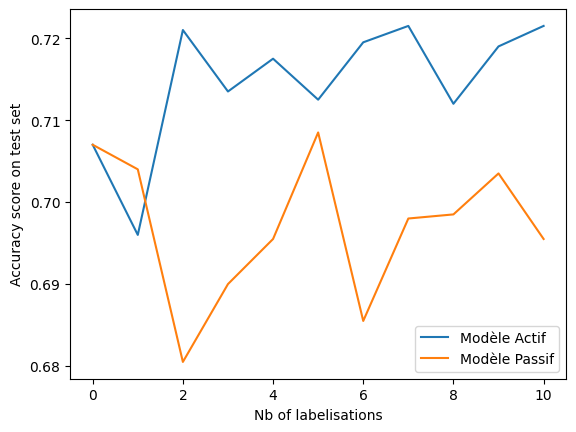

In [12]:
## plot results 
plt.plot(range(n_queries+1), accuracy_model_actif, label='Modèle Actif')
plt.plot(range(n_queries+1), accuracy_model_passif, label='Modèle Passif')
plt.xlabel('Nb of labelisations')
plt.ylabel('Accuracy score on test set')
plt.legend()
plt.show()

## Compare approches

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

(8000, 784)


In [13]:
sizes = [100, 500, 1000, 2000]
accuracies_strats = {'uncertainty_sampling': [], 'margin_sampling': [], 'entropy_sampling': [], 'passive_learner' : []}

In [14]:
for sampling_strategy in accuracies_strats.keys():
    print(f"Testing active learning strategy: {sampling_strategy}")
    
    for size in sizes:
    
        ## Select 20% of data for initial training
        n_initial = size // 2
        initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
        X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
        
        ## remove initial data from training set
        mask = np.ones(len(X_train), dtype=bool)
        mask[initial_idx] = False
        X_train_actif, y_train_actif = X_train[mask], y_train[mask]
        X_train_passif, y_train_passif = X_train[mask], y_train[mask]
        
    
        # Create activ learner
        model_active = RandomForestClassifier()
        
        if sampling_strategy == 'passive_learner':

            model_passive = RandomForestClassifier()
        
            # Train with all dats
            passive_idx = np.random.choice(range(len(X_train)), size=size, replace=False)
            X_passive, y_passive = X_train[passive_idx], y_train[passive_idx]
            model_passive.fit(X_passive, y_passive)
        
            # Predict and compute accuracy
            accuracy_passive = accuracy_score(y_test, model_passive.predict(X_test))
            accuracies_strats[sampling_strategy].append(accuracy_passive)
            
        else :
            
            ## Select corresponding sampling strategy
            if sampling_strategy == 'uncertainty_sampling':
                query_strategy = uncertainty_sampling
            elif sampling_strategy == 'margin_sampling':
                query_strategy = margin_sampling
            elif sampling_strategy == 'entropy_sampling':
                query_strategy = entropy_sampling
        
            learner_active = ActiveLearner(
                estimator=model_active,
                X_training=X_initial, y_training=y_initial,
                query_strategy=query_strategy
            )
            
            learner_active.teach(X_initial, y_initial)
        
            # Simulate labelization
            for idx in range(size - n_initial):
                list_queries = []
                
                query_idx, query_instance = learner_active.query(X_train_actif)
                learner_active.teach(X_train[query_idx], y_train[query_idx])
                
                X_train_actif = np.delete(X_train_actif, query_idx, axis=0)
                y_train_actif = np.delete(y_train_actif, query_idx, axis=0)
                
    
            # Predict with active approach
            accuracy_active = accuracy_score(y_test, learner_active.predict(X_test))
            accuracies_strats[sampling_strategy].append(accuracy_active)
            
            print(X_train_actif.shape, y_train_actif.shape)


Testing active learning strategy: uncertainty_sampling


/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

(7900, 784) (7900,)


/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

(7500, 784) (7500,)


/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

(7000, 784) (7000,)


/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

(6000, 784) (6000,)
Testing active learning strategy: margin_sampling


/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/j.guertin/Library/Python/3.13/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

TypeError: <class 'numpy.ndarray'> datatype is not supported

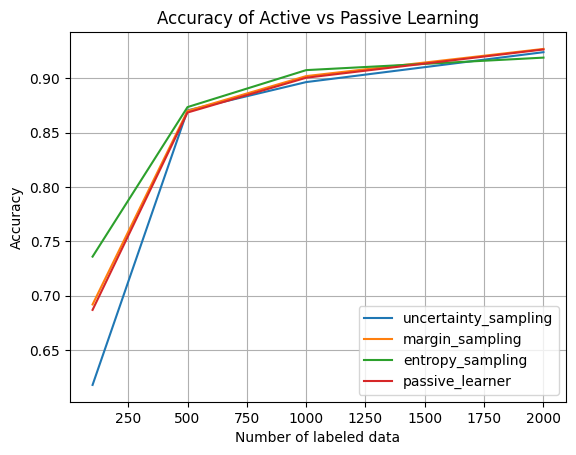

In [ ]:
# Tracer l'évolution des accuracies pour chaque stratégie
for sampling_strategy, accuracies in accuracies_strats.items():
    plt.plot(sizes, accuracies, label=sampling_strategy)

plt.xlabel('Number of labeled data')
plt.ylabel('Accuracy')
plt.title('Accuracy of Active vs Passive Learning')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
accuracies_strats

{'uncertainty_sampling': [0.618, 0.8705, 0.8965, 0.924],
 'margin_sampling': [0.692, 0.87, 0.902, 0.927],
 'entropy_sampling': [0.736, 0.8735, 0.9075, 0.919],
 'passive_learner': [0.687, 0.8685, 0.9005, 0.9265]}